### Imports

In [1]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
from pathlib import Path
from pycurrents.adcp.rdiraw import Multiread

import gvpy as gv
import gadcp

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Moored ADCP Processing

We have two ADCP data files in the testing directory. Let's load the one that comes from the BLT project (thanks NSF!). It was set to burst sampling mode as opposed to the other ADCP.

Parameters for this and the other ADCP (coming from an Arctic deployment very near the ocean surface in the Beaufort Sea) are given below.

In [2]:
# raw_data = Path('../gadcp/tests/data/03160000.000').as_posix()
raw_data = Path('../gadcp/tests/data/24606000.000').as_posix()

In [3]:
# meta_data = {
#     "mooring": "AM1",
#     "sn": 3160,
#     "project": "ARCTIC",
#     "lon": -(145+01.002/60),
#     "lat": 72+35.646/60,
# }
# tgridparams = dict(burst_average=False, dt_hours=5/60)
# editparams = dict()

In [4]:
meta_data = {
    "mooring": "MAVS2",
    "sn": 24606,
    "project": "BLT",
    "lon": -11.843,
    "lat": 54.182,
}
tgridparams = dict(burst_average=True)
editparams = dict()

In [5]:
# dgridparams = dict(dbot=50, dtop=0, d_interval=1)

In [6]:
# dgridparams = dict(dbot=1509, dtop=1141, d_interval=16)

Let the software figure out the best top and bottom limits and interval.

In [7]:
dgridparams = None

Here we provide the clock drift. Note that we are only working with a subset of the real ADCP data file to keep the file size small.

In [8]:
# end_adcp = (2015,9,5,4,2,59)
# end_pc = (2015,9,5,4,2,50)
# driftparams = dict(end_pc=end_pc, end_adcp=end_adcp)

In [9]:
end_adcp = (2021, 10, 7, 12, 7, 12)
end_pc = (2021, 10, 7, 12, 8, 30)
driftparams = dict(end_pc=end_pc, end_adcp=end_adcp)

Set up a processing object. We will take care of the editing parameters in a little bit.

In [10]:
a = gadcp.madcp.ProcessADCP(
    raw_data,
    meta_data=meta_data,
    driftparams=driftparams,
    tgridparams=tgridparams,
    dgridparams=dgridparams,
    editparams=None,
    verbose=False,
)

No depth gridding parameters provided, using default values.
No edit parameters provided, using default values.


time between pings within burst: 3.0 s
time between bursts: 14.0 min
22 pings per burst
365 bursts total


We can see that the burst processing scheme was recognized. All parameters are stored as
attributes.

In [11]:
a.tgridparams

{'dt_hours': 0.5,
 't0': 187.71909722222222,
 't1': 191.51048867947694,
 'burst_average': True}

In [12]:
a.dgridparams

{'dtop': 1141.0, 'dbot': 1509.0, 'd_interval': 16.0}

Now we can start looking into the data.

Reading raw data...


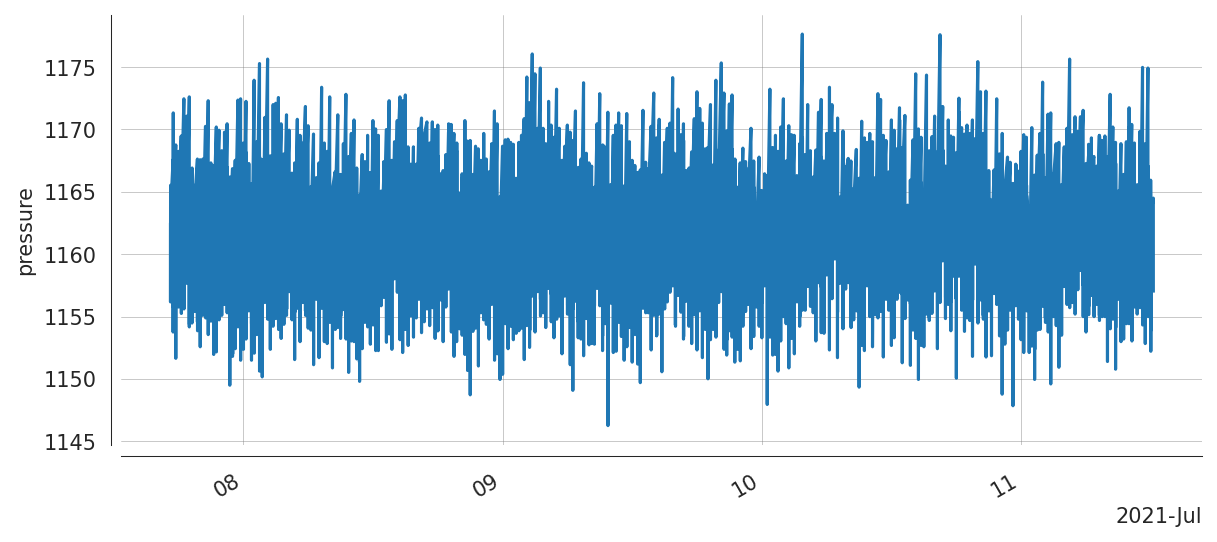

In [13]:
ax = a.raw.pressure.gv.tplot()

Magnetic declination. I think the little magdec command line tool must be installed for this, need to double check.

In [14]:
a.magdec

-4.974683

Run the burst averaging procedure without thinking about editing parameters for now.

In [15]:
a.burst_average_ensembles()

  0%|          | 0/365 [00:00<?, ?it/s]

<AxesSubplot:ylabel='depth [m]'>

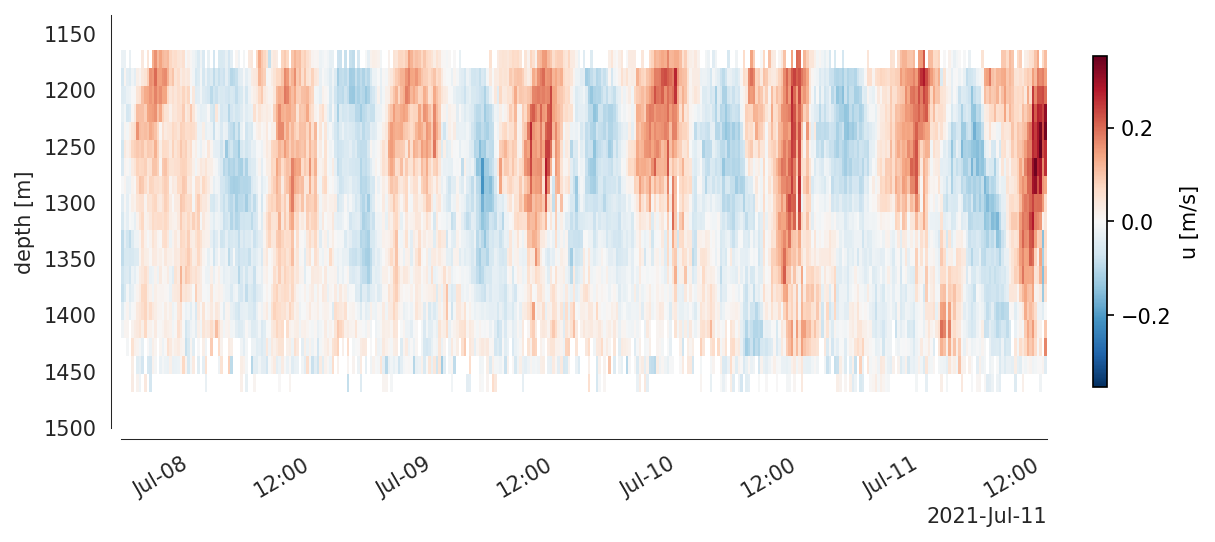

In [16]:
a.ds.u.gv.tplot()

Now we will refine the editing parameters. Let's look at beam statistics. We can see that the first bin may not be that good, and starting at bin 16 the beams hit the ocean bottom. Exclude these from the processing.

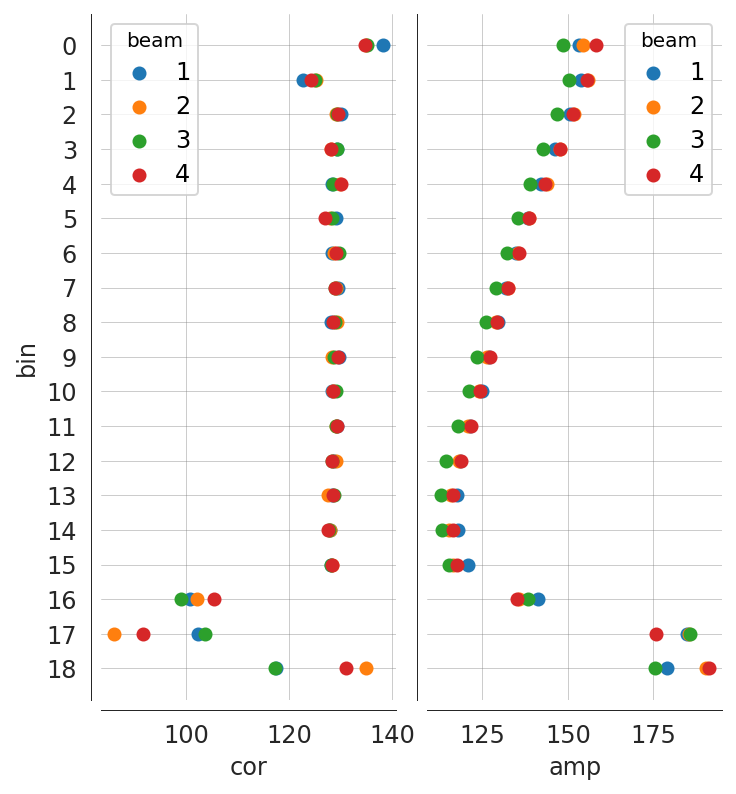

In [17]:
a.plot_echo_stats()

In [18]:
binmask = (a.raw.bin > 15).data
binmask[0] = True

Feed the binmask into the editing parameters. Here we can also provide minimum correlation threshold for individual pings, a maximum error velocity, and a percent good threshold. Percent good is calculated for each average as the number of good data points (or pings) in each bin.

Once we have the dict with the editing parameters, we pass it on to the processing object.

In [19]:
editparams = dict(maskbins=binmask, min_correlation=64, max_e=0.3, pg_limit=50)
a.parse_editparams(editparams)

Let's double check the selected edit parameters:

In [20]:
a.editparams

{'max_e': 0.3,
 'max_e_deviation': 2,
 'min_correlation': 64,
 'maskbins': array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True]),
 'pg_limit': 50}

In [21]:
np.flatnonzero(editparams['maskbins'])

array([ 0, 16, 17, 18])

Run the burst averaging with the new editparams.

In [22]:
a.burst_average_ensembles()

  0%|          | 0/365 [00:00<?, ?it/s]

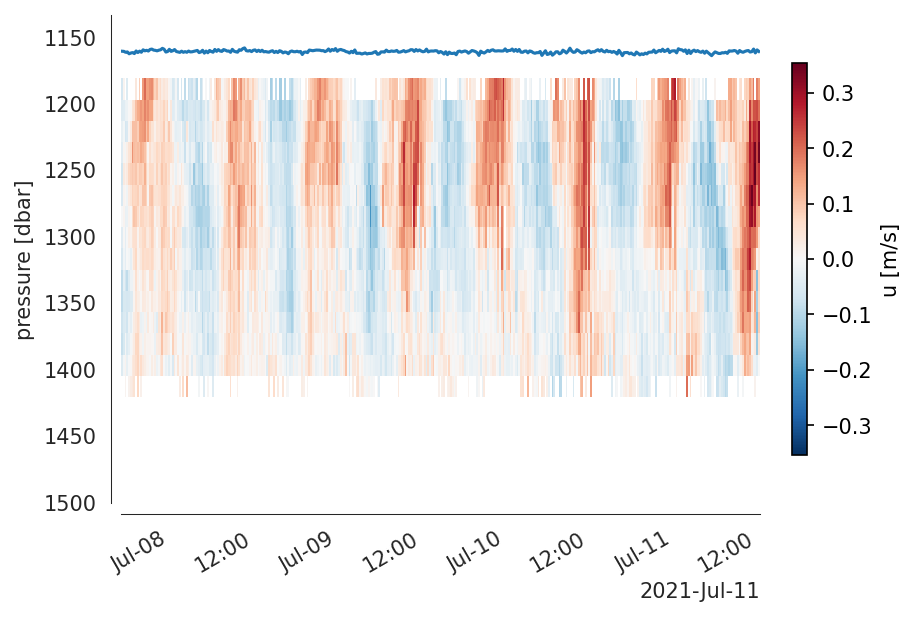

In [23]:
fig, ax = gv.plot.quickfig()
ax = a.ds.u.gv.tplot(ax=ax)
ax = a.ds.pressure.gv.tplot(ax=ax)

In [24]:
a.ds.attrs

{'orientation': 'down',
 'magdec': -4.974683,
 'max_e': 0.3,
 'max_e_deviation': 2,
 'min_correlation': 64,
 'mooring': 'MAVS2',
 'sn': 24606,
 'project': 'BLT',
 'Bin1Dist': 25.55,
 'NCells': 19,
 'CellSize': 16.0,
 'proc time': '2022-04-08T06:46:09'}

Generate plots with the raw data.

In [25]:
adcp = gadcp.io.read_raw_rdi(raw_data)

Plot only auxillary and time-mean quantities.

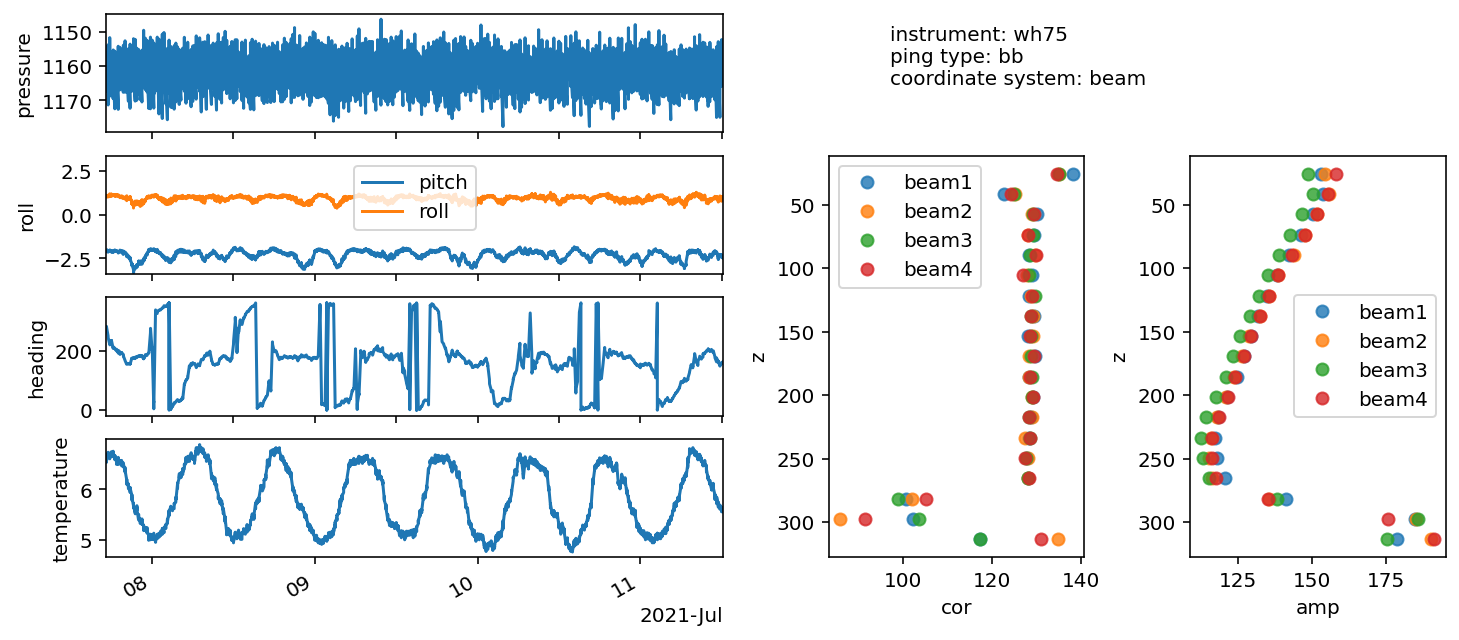

In [26]:
gadcp.adcp.plot_raw_adcp_auxillary(adcp)

Plot all raw data.

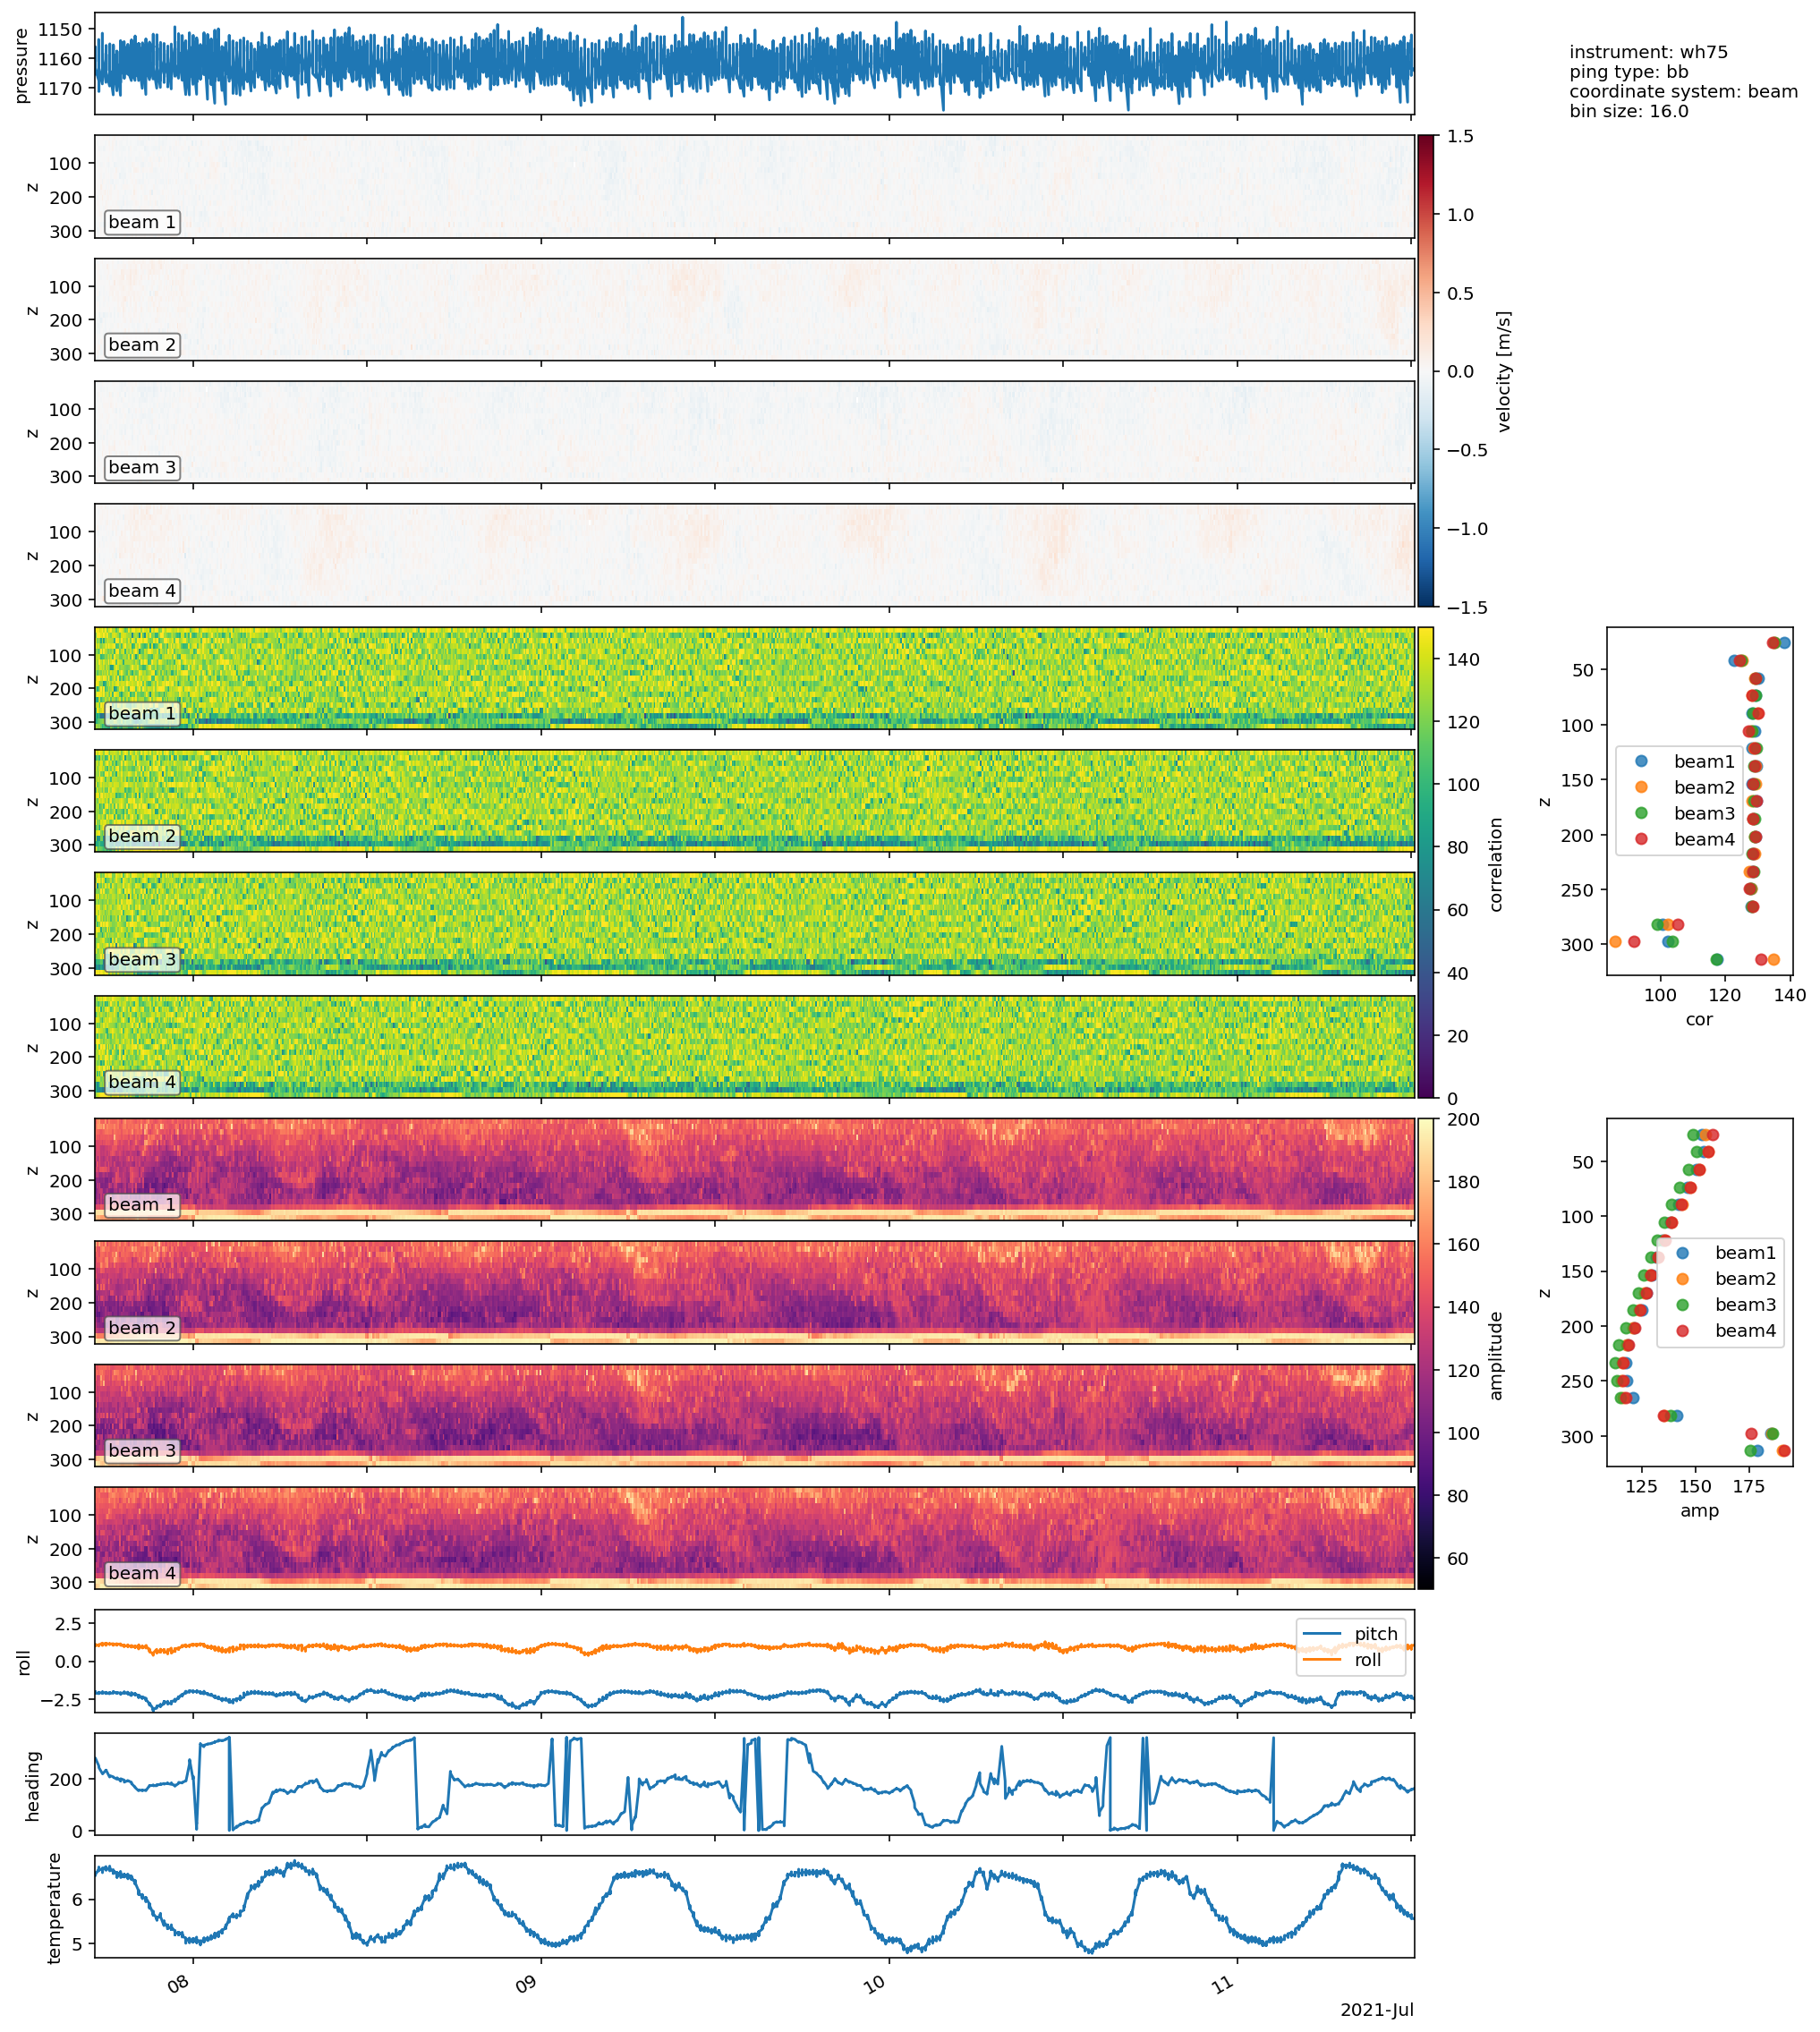

In [27]:
gadcp.adcp.plot_raw_adcp(adcp)